# 0. Marking.

**_IMPORTANT_**: Save a copy of this notebook into your Drive before you start.

- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).

Please submit a zip file, containing both parts, consiting of of:

1. A text file with a publicly visible link to your notebooks in Google Colab or GitHub.
2. A downloaded copy (ipynb) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.


## Imports


In [1]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified; it is working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching ray=="2.6.3" torch torchvision  gdown tqdm seaborn torchsummary pycrypto cryptography=="41.0.2" pycryptodome=="3.18.0" matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.2/446.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.0.0 requires cryptography<43,>=41.0.5, but you have cryptography 41.0.2 which is incompatible.


In [2]:
# Imports
import csv
import numbers
import os
import random
import pickle
from collections import OrderedDict, defaultdict
from collections.abc import Callable
from typing import Any
from copy import deepcopy
from pathlib import Path
from logging import INFO

import flwr as fl
import ray
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import (
    log,
    Metrics,
    Config,
    GetPropertiesIns,
    GetPropertiesRes,
    MetricsAggregationFn,
)
from flwr.client import Client
from flwr.common.parameter import ndarrays_to_parameters, parameters_to_ndarrays
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig, History
from flwr.server.server_returns_parameters import ReturnParametersServer as Server
from flwr.server.client_manager import SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from flwr.server.strategy import Strategy
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum
from datetime import datetime, timezone
import json

# Add new seeds here for easy autocomplete


class Seeds(IntEnum):
    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

PathType = Path | str | None

### Paths


In [3]:
home_dir = content if (content := Path("/content")).exists() else Path.cwd()
data_dir: Path = home_dir / "data"

### Useful Python functions


In [4]:
def convert(o: Any) -> int | float:
    """Convert input object to Python numerical if numpy."""
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.int32 | np.int64):
        return int(o)
    # type: ignore[reportGeneralTypeIssues]
    if isinstance(o, np.float32 | np.float64):
        return float(o)
    raise TypeError


def save_history(hist: History, name: str) -> None:
    """Save history from simulation to file."""
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap simulation to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    return parameter_list, hist

### Dataset


In [5]:
if not (home_dir / "common").exists():
    ! git clone "https://github.com/camlsys/L361-Federated-Learning.git" temp_repo

    # Copy the folder to the current directory
    ! cp -r "temp_repo/labs/common" {home_dir}

    # Delete the cloned repository
    ! rm -rf temp_repo

    # Create the __init__.py file
    (home_dir / "__init__.py").open(mode="a+")

Cloning into 'temp_repo'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 214 (delta 52), reused 50 (delta 34), pack-reused 137
Receiving objects: 100% (214/214), 648.81 KiB | 3.41 MiB/s, done.
Resolving deltas: 100% (121/121), done.


In [6]:
from common.client import FlowerClient, get_flower_client_generator
from common.client_manager import CustomClientManager
from common.strategy import DeterministicSampleFedAvg as FedAvgM
from common.client_utils import (
    get_network_generator_cnn,
    get_model_parameters,
)

In [7]:
np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)
federated_evaluation_function = None

In [8]:
fl_client_gen = get_flower_client_generator(network_generator_cnn, home_dir, home_dir)

# Secure Aggregation


In this section, we will explore a **Secure Multi-Party Computation (SMPC)** based approach first implemented in an FL context in [this](https://arxiv.org/abs/1611.04482) paper, called **Secure Aggregation**.
The authors proposed a protocol for the secure aggregation of model updates in a Federated Learning setting.
SMPC algorithms allow a group of _mutually distrustful parties_ to compute a function over their private inputs without revealing any information about their inputs to one another.
In Federated Learning, users can compute the average of their model updates without revealing any information about their model updates to the other actors.
This is achieved by a complex exchange of encrypted keys and messages between the actors, which is why the protocol is _computationally expensive_.
The additional information the server and clients exchanges results in additional _communication overhead_.
In this Lab, we will focus on the communication overhead, ignoring the computational overhead. Furthermore, the protocol requires a specific fraction of clients to complete training to compute the average.

[Pan Heng](https://github.com/panh99) implemented the first Secure Aggregation in Flower. Thus, we will use part of his code in this section. However, because of the complexity of this protocol, we refer all the discussions to the original paper.
The main takeaways from the paper are the following: private inputs of clients are completely protected in this setting; Secure Aggregation is computationally expensive and requires a lot of communication overhead; the scalability of Secure Aggregation to many clients requires a lot of computational resources.

In the following cell, we will download the code for the Secure Aggregation protocol.


In [9]:
secagg_dir = home_dir / "secagg"

The implementation contains many encryption utilities, and thus it is very complex.
So, feel free to dig into the code, but be aware that it is unnecessary to understand every part of it to complete the Lab.

We also need to create a folder to store the keys generated on the fly by our simulation.


In [10]:
keys_dir = secagg_dir / "client_data"
keys_dir.mkdir(exist_ok=True, parents=True)

We are now importing the relevant functions for simulating the Secure Aggregation protocol from the files we have just downloaded.


In [11]:
from common.secagg.client import get_sec_agg_client_generator as get_client_generator
from common.secagg.strategy import SecureAggregationStrategy

It is important to point out that from now on we will use a toy simulator.
This means that we will not use real clients, so we are not training anything.
We will just simulate the communication between the server and the clients to explore the communication overhead.
The scripts are built to return to the `aggregate_fit` function of the server the length of the bytes exchanged during all the phases of communication of the Secure Aggregation protocol.
The equivalent single FL training round is achieved in 4 phases of communication by the protocol.

It is worth mentioning that for this implementation we will change our training round from using epochs to local steps because we need all the clients to train on the same amount of data samples.
This is done because even the number of samples could be considered sensitive information that we do not want to reveal to the other actors.


In [12]:
num_total_clients = 3290

In [13]:
def run_sec_agg_demo(
    num_clients_per_round: int = 10,
    n_model_parameters: int = 10000,
    min_num_surviving_clients: int = 5,
    n_rounds: int = 2,
    n_samples: int = 30,
) -> Any:
    """Execute a secure aggregation simulation."""
    strategy = SecureAggregationStrategy(
        n_dim=n_model_parameters,
        num_clients_per_round=num_clients_per_round,
        threshold=min_num_surviving_clients,
        num_dropouts=num_clients_per_round - min_num_surviving_clients,
    )
    secagg_hist = start_seeded_simulation(
        client_fn=lambda cid: get_client_generator(
            n_model_parameters, n_samples, keys_dir
        )(cid).to_client(),
        num_clients=num_total_clients,
        # this refers to the number of phases to simulate (must be 4*n_rounds)
        config=ServerConfig(num_rounds=int(4 * n_rounds)),
        strategy=strategy,
        name=f"secagg_{num_clients_per_round}_{n_model_parameters}_{min_num_surviving_clients}_{n_rounds}_{n_samples}",
    )
    # Clean up keys from the folder
    for filename in os.listdir(keys_dir):
        file_pth = keys_dir / filename
        if filename.endswith(".pth"):
            os.remove(file_pth)

    return secagg_hist

In the next cell, we will simulate the Secure Aggregation protocol defined by the abovementioned parameters.


In [14]:
parameters_for_every_round, secagg_hist = run_sec_agg_demo()

INFO flwr 2024-02-25 20:20:51,897 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO flwr 2024-02-25 20:20:51,940 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2024-02-25 20:20:51,946 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2024-02-25 20:20:51,951 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2024-02-25 20:20:51,955 | server_returns_parameters.py:97 | FL starting
INFO:flwr:FL starting
INFO flwr 2024-02-25 20:20:51,958 | strategy.py:118 | Configure fit: stage 0, 0, True
INFO:flwr:Configure fit: stage 0, 0, True
INFO flwr 2024-02-25 20:20:51,967 | strategy.py:120 | Stage 0
INFO:flwr:Stage 0
DEBUG fl

In [15]:
secagg_hist

History (metrics, distributed, fit):
{'total_cost': [(1, 4500), (2, 79160), (3, 401345), (4, 14430), (5, 4500), (6, 79160), (7, 401345), (8, 14430)]}

Looking carefully at the `History` object returned by the simulation, we can see that it contains the key `total_cost`, which couples the round of communication with the number of bytes exchanged during that round.
Note that the values are periodic because of the 4 phases involved in the protocol.


**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Using the function `run_SA_demo`, study the impact of different parameters on the `total_cost`:

1. Draw a scatter plot with the `total_cost` summed across rounds on the y-axis. While keeping all other parameters constant to the above values, vary the `num_clients_per_round` from 10 to 40 using an increment of 10. Use the `num_clients_per_round` as the x-axis.

2. Draw a scatter plot with the `total_cost` summed across rounds on the y-axis. While keeping all other parameters constant to the above values, vary `n_model_parameters` between $2^{10}$ and $2^{15}$ increasing using all the powers of two in the interval. Use the `n_model_parameters` as the x-axis.

3. Describe the trade-offs you see and how they relate to communication overheads.


In [17]:
secagg_hist.metrics_distributed_fit['total_cost']

[(1, 4500),
 (2, 79160),
 (3, 401345),
 (4, 14430),
 (5, 4500),
 (6, 79160),
 (7, 401345),
 (8, 14430)]

In [18]:
num_clientss = np.linspace(10, 40, 4).astype(int)
params_per_client = {}
hists_per_client = {}

for num_clients in num_clientss:
  params, hist = run_sec_agg_demo(num_clients_per_round=num_clients)
  params_per_client[num_clients] = params
  hists_per_client[num_clients] = hist



INFO flwr 2024-02-25 20:23:00,492 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=8, round_timeout=None)
INFO flwr 2024-02-25 20:23:00,517 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2024-02-25 20:23:00,522 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2024-02-25 20:23:00,526 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
INFO flwr 2024-02-25 20:23:00,529 | server_returns_parameters.py:97 | FL starting
INFO:flwr:FL starting
INFO flwr 2024-02-25 20:23:00,531 | strategy.py:118 | Configure fit: stage 0, 0, True
INFO:flwr:Configure fit: stage 0, 0, True
INFO flwr 2024-02-25 20:23:00,535 | strategy.py:120 | Stage 0
INFO:flwr:Stage 0
DEBUG fl

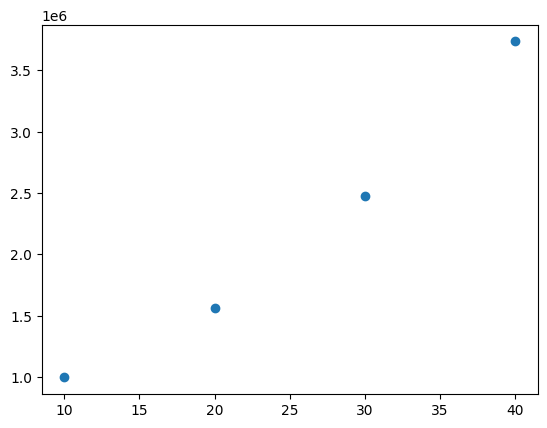

In [20]:
xs = []
ys = []
for num_clients in num_clientss:
  xs.append(num_clients)
  ys.append(sum([total_cost for sum, total_cost in hists_per_client[num_clients].metrics_distributed_fit['total_cost']]))

plt.scatter(xs, ys)



In [19]:
n_parameterss = np.logspace(10, 15, base=2).astype(int)
params_per_n_params = {}
hists_per_n_params = {}

for n_parameters in n_parameterss:
  params, hist = run_sec_agg_demo(n_model_parameters=n_parameters)
  params_per_n_params[n_parameters] = params
  hists_per_n_params[n_parameters] = hist


Streaming output truncated to the last 5000 lines.
INFO flwr 2024-02-25 20:28:59,255 | client.py:99 | CID 3234 reloading from /content/secagg/client_data/3234.pth
INFO:flwr:CID 3234 reloading from /content/secagg/client_data/3234.pth
INFO flwr 2024-02-25 20:28:59,257 | client.py:99 | CID 1603 reloading from /content/secagg/client_data/1603.pth
INFO flwr 2024-02-25 20:28:59,288 | client.py:231 | Client 2: starting stage 2...
INFO:flwr:CID 1603 reloading from /content/secagg/client_data/1603.pth
INFO flwr 2024-02-25 20:28:59,284 | client.py:99 | CID 1260 reloading from /content/secagg/client_data/1260.pth
INFO:flwr:Client 2: starting stage 2...
INFO flwr 2024-02-25 20:28:59,284 | client.py:99 | CID 1571 reloading from /content/secagg/client_data/1571.pth
INFO:flwr:CID 1260 reloading from /content/secagg/client_data/1260.pth
INFO:flwr:CID 1571 reloading from /content/secagg/client_data/1571.pth
INFO flwr 2024-02-25 20:28:59,259 | client.py:99 | CID 2688 reloading from /content/secagg/clie

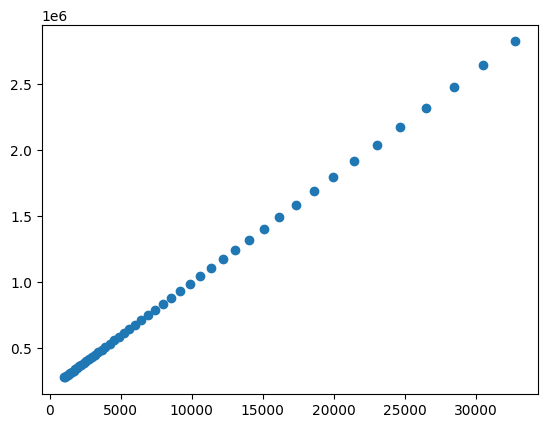

In [22]:
xs = []
ys = []
for n_parameters in n_parameterss:
  xs.append(n_parameters)
  ys.append(sum([total_cost for sum, total_cost in hists_per_n_params [n_parameters].metrics_distributed_fit['total_cost']]))

plt.scatter(xs, ys)



3. The tradeoffs seem to be the following:
  - Commmunication costs increase quadratically in terms of number of clients
  - Commmunication costs increase linearly in terms of number of parameters
The model size seems to make sense, as every message including the model (or its gradients) grows linearly with the number of messages we send. The client number also makes sense, as initially the protocol contains phases where all pairs of clients share their own secrets (e.g. all pairs of users agree on their pairs of input perturbations), which all get sent to the server. So the server receives $O(n^2)$ data points from the $n$ clients.

**Question 10 (Part III/MPhil ✅):**

(This is a purely conceptual question. Answer in **no more than 10 sentences each**.)

After reading the [paper](https://arxiv.org/abs/1611.04482) and experimenting with the additional communication costs of Secure Aggregation in FL, discuss the implication of using this protocol in a real FL setting. You may want to discriminate between cross-silo and cross-device settings. You can focus on communication and computation overheads and refer to the asymptotic complexity of both.


(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani
